## Directory structure

            Face Mask Detection
            ├───data/
            │    ├───annotations/
            │    └───images/
            ├───notebooks/
            │    ├───Data-exploration-and-preprocessing.ipynb
            │    └───Traning-model.ipynb
            ...

## Dataset

This <a href="https://www.kaggle.com/andrewmvd/face-mask-detection">dataset</a> from **Kaggle** contains 853 images belonging to the 3 classes, as well as their bounding boxes in the [**PASCAL VOC**](http://host.robots.ox.ac.uk/pascal/VOC/)(Pascal VOC is a collection of datasets for object detection) format.  

The classes are:  
  
- With mask
- Without mask
- Mask worn incorrectly


In [1]:
# import all the necessary libraries
import os                                            # for accesing the directories
from pathlib import Path                             # for directory path identification
import pandas as pd                                  # for data manipulation and analysis
import numpy as np                                   # for powerful n-dimentional array computation
import pickle                                        # for saving objects and weights
import cv2                                           # for visualizing images
import xml.etree.ElementTree as ET                   # to parse xml file
from tensorflow.keras.utils import to_categorical    # to encode features
import matplotlib.pyplot as plt                      # for ploting graphs

%matplotlib inline

### Set directory path

In [2]:
# set directory path
parent_path = Path(os.getcwd()).parent  # get the parent directory
image_path = os.path.join(parent_path, 'data', 'images')
xml_path = os.path.join(parent_path, 'data', 'annotations')

### Parse xml

In [3]:
# set the lables
label_dict = {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}

imgs = []
# loop through files in directory
for root, dirs, files in os.walk(xml_path):
    
    # loop through the xml file
    for file in files:  
        tree = ET.parse(os.path.join(root, file)) # convert to tree
        data = {'path': None, 'objects': []}
        data['path'] = os.path.join(image_path, tree.find('filename').text)
        
        # loop through the image bounding boxes
        for obj in tree.findall('object'): 
            label = label_dict[obj.find('name').text]
            
            # get the top left co-ordinates
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            
            # geth the bottom right co-ordinates
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            data['objects'].append([label, xmin, ymin, xmax, ymax])
        imgs.append(data)

print('Total images :', len(imgs))

Total images : 855


In [4]:
imgs[:2]

[{'path': 'C:\\Users\\Nathy\\Documents\\Lighthouselabs\\data_bootcamp\\FaceMe\\data\\images\\maksssksksss0.png',
  'objects': [[0, 79, 105, 109, 142],
   [1, 185, 100, 226, 144],
   [0, 325, 90, 360, 141]]},
 {'path': 'C:\\Users\\Nathy\\Documents\\Lighthouselabs\\data_bootcamp\\FaceMe\\data\\images\\maksssksksss1.png',
  'objects': [[1, 321, 34, 354, 69],
   [1, 224, 38, 261, 73],
   [1, 299, 58, 315, 81],
   [1, 143, 74, 174, 115],
   [1, 74, 69, 95, 99],
   [1, 191, 67, 221, 93],
   [1, 21, 73, 44, 93],
   [1, 369, 70, 398, 99],
   [0, 83, 56, 111, 89]]}]

### Vizualize the data(Image)

In [5]:
def draw_box(img, xmin, ymin, xmax, ymax, color, thikness, text):
    
    '''Draws rectangular boxes 
     Write's text above the box'''
    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thikness)
    cv2.putText(img, text, (xmin+2, ymin-3), cv2.FONT_HERSHEY_DUPLEX, 0.8, color, thikness)

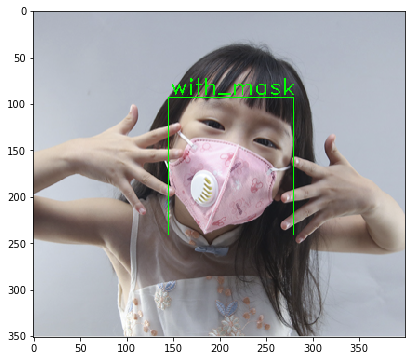

In [138]:
# change label's values to keys
cat_dict = {v: k for k, v in label_dict.items()}

# get a random key
index = np.random.randint(0, len(imgs))
# read the image
img = cv2.imread(imgs[index]['path'])
colors = {0: (0, 0, 255), 1: (0, 255, 0), 2: (0, 255, 255)} # set colors

#loop though the attributes
for (category, xmin, ymin, xmax, ymax) in imgs[index]['objects']:
    
    # Draw rectanges arounf face
    draw_box(img, xmin, ymin, xmax, ymax, colors[category], 1, cat_dict[category])

# Show image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Get Independent and Dependant variables.

In [41]:
# set prefered img size
img_size = (150, 150)
features = []
target = []

for data in imgs:
    #load the image
    img = cv2.imread(data['path'])
    for (category, xmin, ymin, xmax, ymax) in data['objects']:
        # get the face
        face = img[ymin : ymax, xmin : xmax]
        
        # resize face img
        face = cv2.resize(face, img_size)
        
        # add color and append features
        features.append(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        
        # convert independent variables to categorical data
        target.append(to_categorical(category, num_classes=len(cat_dict)))
        

In [100]:
df = pd.DataFrame(target,columns=label_dict.keys())
df = df.apply(pd.value_counts)[1:].transpose().rename(columns={'index':'label',1.0:'count'})
df

,count
without_mask,717
with_mask,3238
mask_weared_incorrect,123


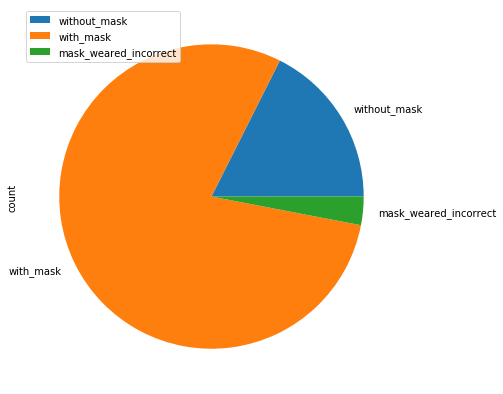

In [108]:
df.plot.pie(y='count', figsize=(15,7))

In [42]:
# save the numpy arrays
np.save('../data/features', np.array(features))
np.save('../data/target', np.array(target))

In [109]:
# save catagory dictionary the pickle file
with open('../data/labels.pkl', 'wb') as pf:
    pickle.dump(cat_dict, pf)